In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta as beta_dist
import matplotlib.pyplot as plt
import random
from operator import truediv

## Data Preprocessing
----
Function for data preprocessing: `preprocessing(version, path, num_started, use_onehot=False)`

Parameters:
1. `version`: specify which type of data the function is processing. Choose between 'optimized' and 'unoptimized'.
2. `path`: path to the original data file.
3. `num_started`: total number of starts of the form. Used to compute submission rate.
4. `use_onehot`: whether to output one-hot encodings for demographic information (gender, age, mood, country, employment).

Returns:
1. `all_data`: a Pandas `DataFrame` object containing all the participant records.
2. `submitted`: a Pandas `DataFrame` object containing only those participants that have submitted the form.
3. `submission_rate`: a `float` type number of the submission rate of the form.

#### Usage
`from preprocess import preprocessing`


Note: please convert the original data files from `.xlsx` to `.xls` in order to be read by pandas.

### Data Preprocessing module written by:
Weiming Ren (weiming.ren@mail.utoronto.ca)

In [2]:
def preprocessing(version, path, num_started, use_onehot=False):
    df = pd.read_excel(path)
    
    demographic_header = ['user_id', 'gender', 'age', 'mood', 'country', 'employment']
    stat_header = ['is_submitted', 'completion_rate', 'start_date', 'submit_date', 'user_rating']
    
    if version == 'optimized':
        total_question_num = 13.
        # compute completion rate
        num_missing = df.iloc[:, [14, 31]].apply(lambda x: x.isnull().sum(), axis=1)
        num_missing += df.iloc[:, 18:23].apply(lambda x: 1 if x.isnull().sum() == 5 else 0, axis=1)

        completion_rate = (total_question_num - num_missing) / total_question_num
        is_submitted = pd.Series(np.ones(completion_rate.shape))

        # process demographic info
        demographic_info = df.iloc[:, [0, 2, 4, 5, 6, 7]]
        demographic_info = demographic_info.set_axis(demographic_header, axis=1)
        
        # extract statistics
        date = df.iloc[:, [-3, -2]]
        rating = df.iloc[:, -4]
        stat = pd.concat([is_submitted, completion_rate, date, rating], axis=1)
        stat = stat.set_axis(stat_header, axis=1)

    elif version == 'unoptimized':
        total_question_num = 14.
        num_missing = df.iloc[:, 7:21].apply(lambda x: x.isnull().sum(), axis=1)
        completion_rate = (total_question_num - num_missing) / total_question_num
        is_submitted = pd.Series(np.ones(completion_rate.shape))
        
        # process demographic info
        demographic_info = df.iloc[:, [0, 4, 3, 2, 6, 5]]
        demographic_info = demographic_info.set_axis(demographic_header, axis=1)
        
        # extract statistics
        date = df.iloc[:, [-3, -2]]
        rating = df.iloc[:, -4]
        stat = pd.concat([is_submitted, completion_rate, date, rating], axis=1)
        stat = stat.set_axis(stat_header, axis=1)
    else:
        return None
    
    if use_onehot:
            demographic_info = pd.get_dummies(demographic_info, columns=demographic_header[1:])
    submitted = pd.concat([demographic_info, stat], axis=1)
    num_submitted = submitted.shape[0]
    
    # generate drop-out samples
    df_unsubmit = pd.DataFrame(
        data=[[np.nan for i in range(submitted.shape[1])] for j in range(num_started - num_submitted)],
        columns=demographic_header + stat_header)
    df_unsubmit['is_submitted'] = 0
    df_unsubmit['user_rating'] = 1
    all_data = submitted.copy().append(df_unsubmit)

    return all_data, submitted, num_submitted / num_started

### Form A (Unoptimized)

In [3]:
unoptimized, unoptimized_submitted, unoptimized_submit_rate = preprocessing(
    version='unoptimized',
    path='Unoptimized_form_responses.xls',
    num_started=104)

unoptimized.head()

,user_id,gender,age,mood,country,employment,is_submitted,completion_rate,start_date,submit_date,user_rating
0,46frmxtucaj9ds46td2zurh7kp7pphzt,Female,22,Good! (My name is Sarah btw not Sarag),Canada,I am a student!,1.0,1.000000,2021-12-01 16:11:20,2021-12-01 16:17:59,4
1,a4y67hz7f14hvs9mupka4y67hzemd9zb,Male,25,Good,Canada,Unemployed,1.0,1.000000,2021-11-29 04:07:54,2021-11-29 04:12:24,5
2,mh08iexfqxwdz8wfmh08ik0z7g5s8ei2,Female,23 years,Good,India,Student,1.0,1.000000,2021-11-27 19:37:25,2021-11-27 19:40:55,5
3,y4u3tbudd65ydu4t6uy4u3vatlu1k9f7,Male,25,tired,Canada,employed (PhD candidate),1.0,1.000000,2021-11-24 21:41:23,2021-11-24 21:55:00,4
4,u0787glnkkzxawybmv65u0787g4h5upu,Female,22,Stressed,Canada,Employed part-time,1.0,0.928571,2021-11-24 20:46:14,2021-11-24 20:53:54,3


### Form B (Optimized)

In [4]:
optimized, optimized_submitted, optimized_submit_rate = preprocessing(
    version='optimized',
    path='Optimized_form_responses.xls',
    num_started=82)

optimized.head()

,user_id,gender,age,mood,country,employment,is_submitted,completion_rate,start_date,submit_date,user_rating
0,56rv8s6p8lutntzkp0wc56rv8s2btsew,He/him,18 - 40 years,Happy,Canada,Student,1.0,0.923077,2021-12-02 03:20:55,2021-12-02 03:24:44,5
1,igrcnp94k6gi6y3r66igrcnp76yi4au8,He/him,18 - 40 years,Happy,Canada,Student,1.0,1.000000,2021-12-02 03:16:32,2021-12-02 03:21:00,4
2,e9x9dnhobh8zwixe9x9dnhgzcrwebst2,He/him,18 - 40 years,Neutral,India,Employed,1.0,1.000000,2021-11-29 02:48:05,2021-11-29 02:51:37,4
3,331a23d1wp937xen331acokyopud6rk1,He/him,18 - 40 years,Neutral,Canada,Student,1.0,1.000000,2021-11-27 17:39:28,2021-11-27 17:43:25,5
4,kgal6gam3h0neojd1hq0kgal6gz6ckql,She/her,18 - 40 years,Neutral,Canada,Student,1.0,1.000000,2021-11-24 20:56:04,2021-11-24 21:11:02,5


### The Epsilon-Greedy Algorithm for Reinforcement Learning

Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly.The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.

Considerations for this algorithm:

1. Prior  : 0 (No Information)
2. Reward : Rating Given by user
3. Epsilon Values : [0.1,0.2,0.3,0.4,0.5,0.6,0.7]

Functions:

1. `choose_form(epsilon,cum_reward_arm0,cum_reward_arm1)`: Function generates a random number between 0 and 1.If    it’s greater than epsilon, it directs us to exploit function. Otherwise, it directs us to the explore function.
2. `exploit(cum_reward_arm0,cum_reward_arm1)`: Function which instructs us to choose the form that 
    has highest cumlative reward (our “greedy” action)
3. `explore()`:Function which instructs us to choose randomly among the two forms 



### Module written by:
Parul Saini (parul.saini@mail.utoronto.ca)

Reference: https://medium.com/analytics-vidhya/the-epsilon-greedy-algorithm-for-reinforcement-learning-5fe6f96dc870

### Simulation 1: Reward is user rating

In [5]:
random.seed(0)
def explore():
    
    return random.choice(forms)

def exploit(cum_reward_arm0,cum_reward_arm1):
    
    if cum_reward_arm0>cum_reward_arm1:
        return 0
    elif cum_reward_arm1>cum_reward_arm0:
        return 1
    else:
        explore()
    
def choose_form(epsilon,cum_reward_arm0,cum_reward_arm1):
    
    if random.random()>epsilon:
        return exploit(cum_reward_arm0,cum_reward_arm1)
    else:
        return explore()

'''
Let '0' represent Form-A(unoptimized) and '1' represent Form-B(optimized)
'''
forms=[0,1]

# Best Form Based on Data(High average reward)
avg_rwd_arm0 = sum(unoptimized['user_rating'])/len(unoptimized)
avg_rwd_arm1 = sum(optimized['user_rating'])/len(optimized)
means=[avg_rwd_arm0,avg_rwd_arm1]
best_form = np.argmax(means)

#Data
rwd_list_arm0 = list(unoptimized['user_rating'].copy())
rwd_list_arm1 = list(optimized['user_rating'].copy())
random.shuffle(rwd_list_arm0)
random.shuffle(rwd_list_arm1)

#No. of Iterations
N= min(len(rwd_list_arm1),len(rwd_list_arm0))
  
#plot variables
plot_regret=[]
plot_selection_rate=[]
plot_cum_reward=[]

colors = ['r', 'b','g','c','m','y','k']
epsilon=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]
for eps in epsilon: 
    
    #prior 
    rwd_arm0 = 0
    rwd_arm1 = 0
    
    #Variables for cumulative reward calculation
    cum_rwd_arm0=0
    cum_rwd_arm1=0
    cum_rwd = 0
    rwd_list=[]
    
    
    #Variables for cumulative regret calculation
    regret=[]
    cum_reg=0
    
    #Variables for mean selection rate calculation
    mean_rate=0
    mean_rate_list=[]
    
    #pointer variables
    iter_optimized=0
    iter_unoptimized=0    
      
    for i in range(1,N+1):
        chosen_form = choose_form(eps,cum_rwd_arm0,cum_rwd_arm1)
        
        #Calculate Cumulative Rewards
        if chosen_form==0:
            reward0 = rwd_list_arm0[iter_unoptimized]
            iter_unoptimized += 1
            cum_rwd_arm0 = cum_rwd_arm0 + reward0
   
            #We calculate regret since chosen_form!=best_form 
            cum_reg = cum_reg+1

            cum_rwd=cum_rwd+reward0
            
        if chosen_form==1:
            reward1=rwd_list_arm1[iter_optimized]
            iter_optimized += 1
            cum_rwd_arm1 = cum_rwd_arm1 + reward1

            cum_rwd=cum_rwd+reward1
        
        
        #for calculation of mean selection rate
        mean_rate=round((iter_optimized/i)*100,2)
        mean_rate_list.append(mean_rate)
        
        #cumulative reward over each iteration
        rwd_list.append(cum_rwd)
        
        #cumulative regret over each iteration
        regret.append(cum_reg)
        
    plot_cum_reward.append([rwd_list,eps])
    plot_regret.append([regret,eps])
    plot_selection_rate.append([mean_rate_list,eps])
    

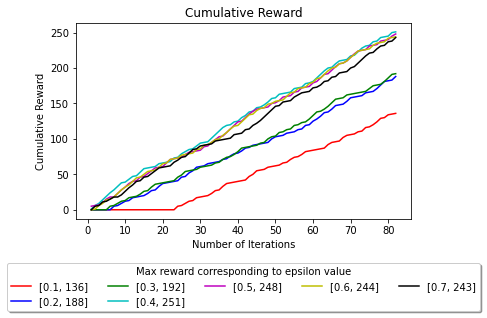

In [6]:
#Plot cumulative reward 

fig = plt.figure()
ax = plt.subplot(111)

for j,item in enumerate(plot_cum_reward):
    x=list(range(1,N+1))
    y=item[0]
    eps=item[1]
    max_rwd =item[0][len(y)-1]
    plt.title('Cumulative Reward')
    ax.plot(x,y,color=colors[j],label= [eps,round(max_rwd,2)])
    plt.xlabel('Number of Iterations')
    plt.ylabel('Cumulative Reward')
    

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5,title='Max reward corresponding to epsilon value')


plt.show()

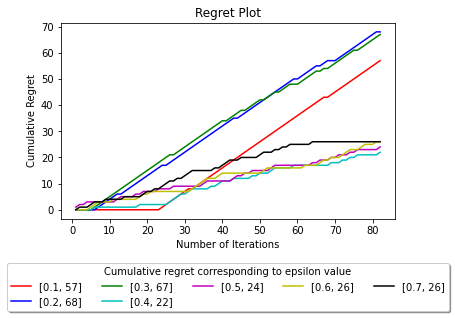

In [7]:
#Plot Regret

fig = plt.figure()
ax = plt.subplot(111)

for j,item in enumerate(plot_regret):
    x=list(range(1,N+1))
    y=item[0]
    eps=item[1]
    max_regret = item[0][len(y)-1]
    plt.title('Regret Plot')
    ax.plot(x,y,color=colors[j],label= [eps,round(max_regret,2)])
    plt.xlabel('Number of Iterations')
    plt.ylabel('Cumulative Regret')
    plt.legend(loc='lower right',title = 'eps')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5,title='Cumulative regret corresponding to epsilon value')


plt.show()

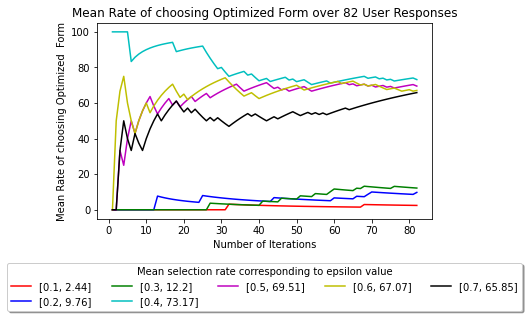

In [8]:
#Plot Mean Selection Rate for Optimized Form

fig = plt.figure()
ax = plt.subplot(111)

for j,item in enumerate(plot_selection_rate):
    x=list(range(1,N+1))
    y=item[0]
    eps=item[1]
    max_rate = item[0][len(y)-1]
    plt.title('Mean Rate of choosing Optimized Form over 82 User Responses')
    ax.plot(x,y,color=colors[j],label= [eps,round(max_rate,2)])
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Rate of choosing Optimized  Form')
    plt.legend(loc='lower right',title = 'eps')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5,title='Mean selection rate corresponding to epsilon value')


plt.show()


### Simulation 2: Reward is whether a form is submitted or not

In [9]:
random.seed(0)
def explore():
    
    return random.choice(forms)

def exploit(cum_reward_arm0,cum_reward_arm1):
    
    if cum_reward_arm0>cum_reward_arm1:
        return 0
    elif cum_reward_arm1>cum_reward_arm0:
        return 1
    else:
        explore()
    
def choose_form(epsilon,cum_reward_arm0,cum_reward_arm1):
    
    if random.random()>epsilon:
        return exploit(cum_reward_arm0,cum_reward_arm1)
    else:
        return explore()

'''
Let '0' represent Form-A(unoptimized) and '1' represent Form-B(optimized)
'''
forms=[0,1]

# Best Form Based on Data(High average reward)
avg_rwd_arm0 = sum(unoptimized['user_rating'])/len(unoptimized)
avg_rwd_arm1 = sum(optimized['user_rating'])/len(optimized)
means=[avg_rwd_arm0,avg_rwd_arm1]
best_form = np.argmax(means)

#Data
rwd_list_arm0 = list(unoptimized['is_submitted'].copy())
rwd_list_arm1 = list(optimized['is_submitted'].copy())
random.shuffle(rwd_list_arm0)
random.shuffle(rwd_list_arm1)

#No. of Iterations
N= min(len(rwd_list_arm1),len(rwd_list_arm0))
  
#plot variables
plot_regret_eps=[]
plot_selection_rate_eps=[]
plot_cum_reward_eps=[]

colors = ['r', 'b','g','c','m','y','k']
epsilon=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]
for eps in epsilon: 
    
    #prior 
    rwd_arm0 = 0
    rwd_arm1 = 0
    
    #Variables for cumulative reward calculation
    cum_rwd_arm0=0
    cum_rwd_arm1=0
    cum_rwd = 0
    rwd_list=[]
    
    
    #Variables for cumulative regret calculation
    regret_eps=[]
    cum_reg=0
    
    #Variables for mean selection rate calculation
    mean_rate=0
    mean_rate_list=[]
    
    #pointer variables
    iter_optimized=0
    iter_unoptimized=0
      
    for i in range(1,N+1):
        chosen_form = choose_form(eps,cum_rwd_arm0,cum_rwd_arm1)
        
        #Calculate Cumulative Rewards
        if chosen_form==0:
            if rwd_list_arm0[iter_unoptimized]==0:
                reward0 = 0
            else:
                reward0 = 1
            iter_unoptimized += 1
            cum_rwd_arm0 = cum_rwd_arm0 + reward0
  
            #We calculate regret since chosen_form!=best_form 
            cum_reg = cum_reg+1

            cum_rwd=cum_rwd+reward0
            
        if chosen_form==1:
            if rwd_list_arm1[iter_optimized]==0:
                reward1=0
            else:
                reward1 =1
            iter_optimized += 1
            cum_rwd_arm1 = cum_rwd_arm1 + reward1

            cum_rwd=cum_rwd+reward1
        
        #for calculation of mean selection rate
        mean_rate=round((iter_optimized/i)*100,2)
        mean_rate_list.append(mean_rate)
            
        #cumulative reward over each iteration
        rwd_list.append(cum_rwd)
        
        #cumulative regret over each iteration
        regret_eps.append(cum_reg)
        
    plot_cum_reward_eps.append([rwd_list,eps])
    plot_regret_eps.append([regret_eps,eps])
    plot_selection_rate_eps.append([mean_rate_list,eps])
    


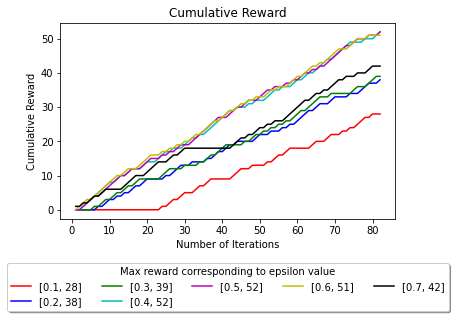

In [10]:
#Plot cumulative reward 

fig = plt.figure()
ax = plt.subplot(111)

for j,item in enumerate(plot_cum_reward_eps):
    x=list(range(1,N+1))
    y=item[0]
    eps=item[1]
    max_rwd =item[0][len(y)-1]
    plt.title('Cumulative Reward')
    ax.plot(x,y,color=colors[j],label= [eps,round(max_rwd,2)])
    plt.xlabel('Number of Iterations')
    plt.ylabel('Cumulative Reward')
    

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5,title='Max reward corresponding to epsilon value')


plt.show()

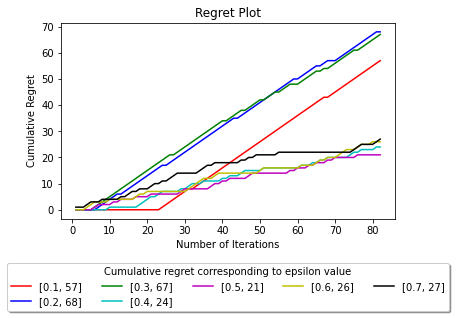

In [11]:
#Plot Regret

fig = plt.figure()
ax = plt.subplot(111)

for j,item in enumerate(plot_regret_eps):
    x=list(range(1,N+1))
    y=item[0]
    eps=item[1]
    max_regret = item[0][len(y)-1]
    plt.title('Regret Plot')
    ax.plot(x,y,color=colors[j],label= [eps,round(max_regret,2)])
    plt.xlabel('Number of Iterations')
    plt.ylabel('Cumulative Regret')
    plt.legend(loc='lower right',title = 'eps')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5,title='Cumulative regret corresponding to epsilon value')


plt.show()

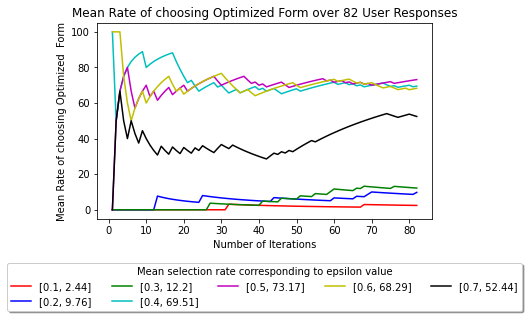

In [12]:
#Plot Mean Selection Rate for Optimized Form

fig = plt.figure()
ax = plt.subplot(111)

for j,item in enumerate(plot_selection_rate_eps):
    x=list(range(1,N+1))
    y=item[0]
    eps=item[1]
    max_rate = item[0][len(y)-1]
    plt.title('Mean Rate of choosing Optimized Form over 82 User Responses')
    ax.plot(x,y,color=colors[j],label= [eps,round(max_rate,2)])
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Rate of choosing Optimized  Form')
    plt.legend(loc='lower right',title = 'eps')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=True, ncol=5,title='Mean selection rate corresponding to epsilon value')


plt.show()



### Beta-Bernoulli Bandit and Thompson sampling

Two bandit arms:
1. Optimized webform
2. Unoptimized webform

Initialization: $Beta(1, 1)$ (uniform distribution) for both arms

### Module written by:
Weiming Ren (weiming.ren@mail.utoronto.ca)

Reference: https://gdmarmerola.github.io/ts-for-bernoulli-bandit/

### Reward
As we are using the Bernoulli bandit, the reward of the arms would be either 0 or 1. We define the reward of an arm as:
- 0 if the participant started but did not submit the form.
- 1 if the participant submitted the form.

From the dataset, we know that the submission rate for the two forms are:

In [13]:
print("Submission rate for the unoptimized form: {}".format(unoptimized_submit_rate))
print("Submission rate for the optimized form: {}".format(optimized_submit_rate))

Submission rate for the unoptimized form: 0.4326923076923077
Submission rate for the optimized form: 0.6707317073170732


which indicates that the probability of a participant submit the form given it is an unoptimized/optimized form is 0.43/0.67. We will see how the Thompson sampling algorithm captures this probability during its computation.

In [14]:
# function for plotting the beta distribution curve of the two arms during iteration
def plot_beta_distributions(unoptimized, optimized, n_steps, vline=True):
    fig = plt.figure(figsize=(12, 4))
    X = np.linspace(0, 1, 1000)
    
    dist = beta_dist(1 + unoptimized[0], 1 + unoptimized[1])
    curve = dist.pdf(X)
    
    ax = fig.add_subplot(1, 2, 1)
    ax.fill_between(X, 0, curve, color='red', alpha=0.7)
    if vline:
        markerline, stemlines, baseline = ax.stem(
            X[np.argmax(curve)], curve[np.argmax(curve)],
            linefmt='--',markerfmt='o', label=str(X[np.argmax(curve)])[:4])
        plt.setp(markerline, 'color', 'black')
        plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
        plt.setp(stemlines, 'linestyle', 'dotted')
        ax.text(X[np.argmax(curve)]+0.02, 0.2, s=str(X[np.argmax(curve)])[:4])
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=8)
    ax.set_title("Unoptimized Distribution - {} iterations".format(n_steps))
    
    dist = beta_dist(1 + optimized[0], 1 + optimized[1])
    curve = dist.pdf(X)
    
    ax = fig.add_subplot(1, 2, 2)
    ax.fill_between(X, 0, curve, color='green', alpha=0.7)
    if vline:
        markerline, stemlines, baseline = ax.stem(
            X[np.argmax(curve)], curve[np.argmax(curve)],
            linefmt='--',markerfmt='o', label=str(X[np.argmax(curve)])[:4])
        plt.setp(markerline, 'color', 'black')
        plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
        plt.setp(stemlines, 'linestyle', 'dotted')
        ax.text(X[np.argmax(curve)]+0.02, 0.2, s=str(X[np.argmax(curve)])[:4])
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=8)
    ax.set_title("Optimized Distribution - {} iterations".format(n_steps))
    plt.show()

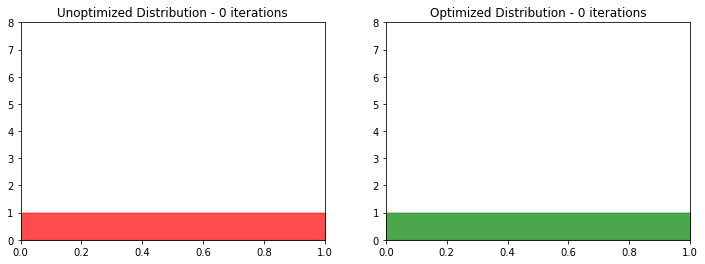

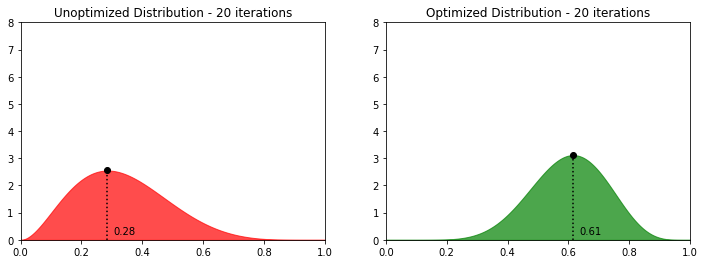

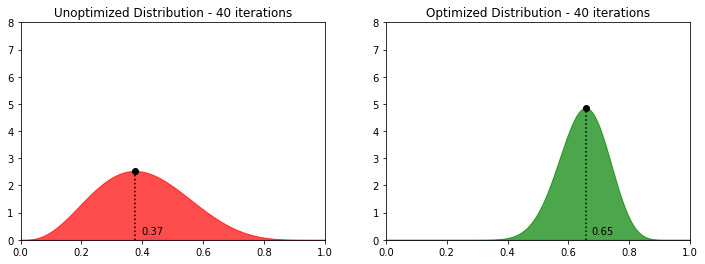

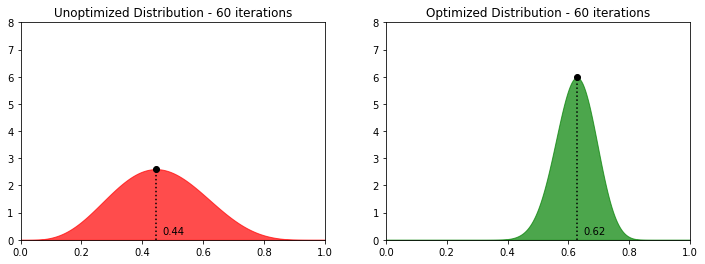

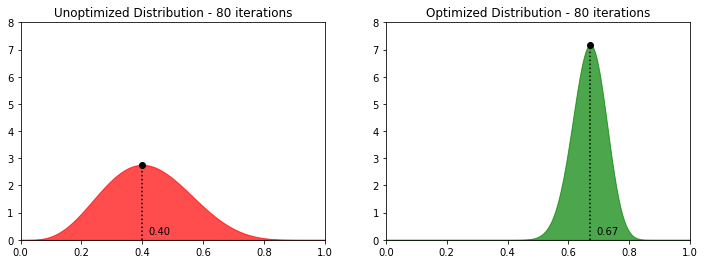

In [15]:
# config
np.random.seed(7)
n_steps = 82
plot_interval = 20

# prepare datasets
unoptimized_loader = unoptimized.sample(frac=1).reset_index(drop=True)
optimized_loader = optimized.sample(frac=1).reset_index(drop=True)

iter_unoptimized = 0
iter_optimized = 0

# prior distribution for both arm: Beta(1, 1)
beta_unoptimized = [0, 0]
beta_optimized = [0, 0]

cur_regret_ts = 0
regret_ts = []
mean_rate_list_ts = []
mean_rate_ts = 0

# plot initial distributions
plot_beta_distributions(beta_unoptimized, beta_optimized, 0, vline=False)

for i in range(n_steps):
    # draw from arm distributions
    val_unoptimized = np.random.beta(1 + beta_unoptimized[0], 1 + beta_unoptimized[1])
    val_optimized = np.random.beta(1 + beta_optimized[0], 1 + beta_optimized[1])
    
    # random sample from the chosen arm
    if val_unoptimized > val_optimized:
        cur_regret_ts += 1
        sample = unoptimized_loader.iloc[iter_unoptimized, :]
        iter_unoptimized += 1
        beta_unoptimized[1 - int(sample['is_submitted'])] += 1
        
    else:
        sample = optimized_loader.iloc[iter_optimized, :]
        iter_optimized += 1
        beta_optimized[1 - int(sample['is_submitted'])] += 1
    
    mean_rate_ts = round((iter_optimized / (i + 1)) * 100, 2)
    mean_rate_list_ts.append(mean_rate_ts)
        
    regret_ts.append(cur_regret_ts)
    
    if (i + 1) % plot_interval == 0:
        plot_beta_distributions(beta_unoptimized, beta_optimized, i + 1)

X = np.linspace(0, 1, 1000)
dist = beta_dist(1 + beta_optimized[0], 1 + beta_optimized[1])
curve = dist.pdf(X)

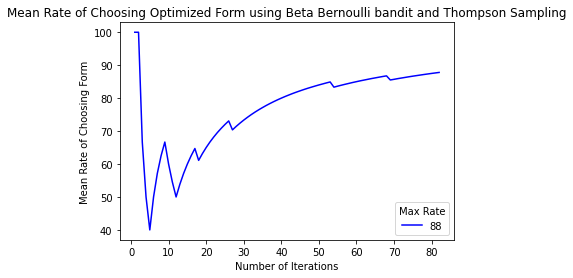

In [16]:
# plot mean rate of choosing the optimized form using TS
max_rate = mean_rate_list_ts[N-1]
plt.title('Mean Rate of Choosing Optimized Form using Beta Bernoulli bandit and Thompson Sampling')
plt.plot(x,mean_rate_list_ts,color='blue',label= round(max_rate))
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Rate of Choosing Form')

plt.legend(loc='lower right',title = 'Max Rate')
plt.show()

### Random A/B Experiment

Analysing results of A/B experiment

### Module written by:
Parul Saini (parul.saini@mail.utoronto.ca)

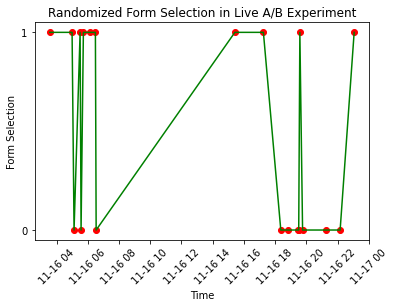

In [17]:
import datetime

time_0= list(unoptimized['start_date'].copy())
cleanedTime_0 = [[datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'),0] for x in time_0 if x == x]
time_1= list(optimized['start_date'].copy())
cleanedTime_1 = [[datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'),1] for x in time_1 if x == x]

#Merge lists
responses=cleanedTime_0
responses.extend(cleanedTime_1 )

#Sort responses based on start date
sorted_list=sorted(responses, key=lambda x: x[0])

time=[x[0] for x in sorted_list if x[0].date()==datetime.date(2021,11,16)]
form=[x[1] for x in sorted_list if x[0].date()==datetime.date(2021,11,16)]

#Plot 
plt.title('Randomized Form Selection in Live A/B Experiment')
plt.ylabel('Form Selection')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.yticks([0,1])
plt.scatter(time,form,color='red')
plt.plot(time,form,color='green')

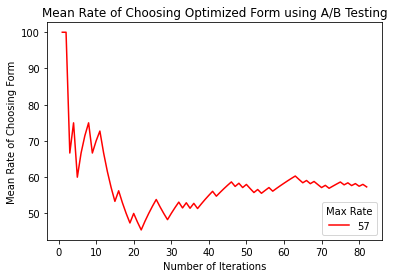

In [18]:
#Performance of A/B experiment
#No. of Iterations
iter_optimized=0
iter_unoptmized=0
mean_rate_list_ab=[]

N=82
form=[x[1] for x in sorted_list]
cum_reg =0
regret_ab=[]
for i in range(1,N+1):
    if form[i-1]==1:
        iter_optimized += 1
    if form[i-1]==0:
        cum_reg = cum_reg+1
        
    regret_ab.append(cum_reg)
        
    #for calculation of mean selection rate
    mean_rate=round((iter_optimized/i)*100,2)
    mean_rate_list_ab.append(mean_rate)
       
#Plot Mean Selection Rate for Optimized Form
x =list(range(1,N+1))

max_rate = mean_rate_list_ab[N-1]
plt.title('Mean Rate of Choosing Optimized Form using A/B Testing')
plt.plot(x,mean_rate_list_ab,color='red',label= round(max_rate))
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Rate of Choosing Form')

plt.legend(loc='lower right',title = 'Max Rate')
plt.show()  

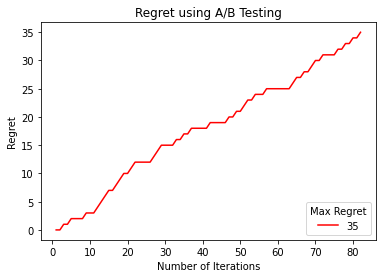

In [19]:
#Plot Regret
x =list(range(1,N+1))

max_regret_ab = regret_ab[N-1]
plt.title('Regret using A/B Testing')
plt.plot(x,regret_ab,color='red',label= round(max_regret_ab))
plt.xlabel('Number of Iterations')
plt.ylabel('Regret')

plt.legend(loc='lower right',title = 'Max Regret')
plt.show() 

### Performance Comparison - A/B Testing , Epsilon Greedy & Thompsons Sampling

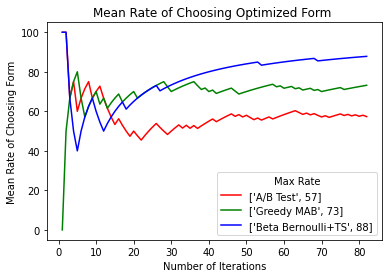

In [20]:
x =list(range(1,N+1))

for j,item in enumerate(plot_selection_rate_eps):
    eps=item[1]
    if eps==0.5:
        y=item[0]
        max_rate_eps = item[0][len(y)-1]

#Mean Rate Comparison:
max_rate_ab = mean_rate_list_ab[N-1]
max_rate_ts = mean_rate_list_ts[N-1]
plt.title('Mean Rate of Choosing Optimized Form ')
plt.plot(x,mean_rate_list_ab,color='red',label= ['A/B Test',round(max_rate_ab)])
plt.plot(x,y,color='green',label= ['Greedy MAB',round(max_rate_eps)])
plt.plot(x,mean_rate_list_ts,color='blue',label= ['Beta Bernoulli+TS',round(max_rate_ts)])
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Rate of Choosing Form')

plt.legend(loc='lower right',title = 'Max Rate')
plt.show()  

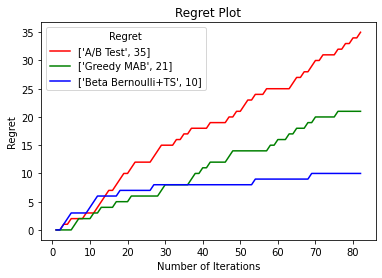

In [21]:
x =list(range(1,N+1))

for j,item in enumerate(plot_regret_eps):
    eps=item[1]
    if eps==0.5:
        regret_eps=item[0]
        max_regret_eps = item[0][len(regret_eps)-1]

#Mean Rate Comparison:
max_regret_ab = regret_ab[N-1]
max_regret_ts = regret_ts[N-1]
plt.title('Regret Plot')
plt.plot(x,regret_ab,color='red',label= ['A/B Test',round(max_regret_ab)])
plt.plot(x,regret_eps,color='green',label= ['Greedy MAB',round(max_regret_eps)])
plt.plot(x,regret_ts,color='blue',label=['Beta Bernoulli+TS',round(max_regret_ts)])
plt.xlabel('Number of Iterations')
plt.ylabel('Regret')

plt.legend(loc='upper left',title = 'Regret')
plt.show()  